# Melanoma Cancer

I am using a data set from here: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset

In [17]:
import os
import pandas as pd

from torchvision import models, datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from warnings import filterwarnings

In [27]:
current_dir = os.getcwd()
dataset_dir = os.path.join(current_dir,'Dataset')
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir,'test')

print(current_dir)
print(train_dir)
print(test_dir)

/Users/mjg/Desktop/5. Coding/5. CV/20. CNN/2. Melanoma Cancer
/Users/mjg/Desktop/5. Coding/5. CV/20. CNN/2. Melanoma Cancer/Dataset/train
/Users/mjg/Desktop/5. Coding/5. CV/20. CNN/2. Melanoma Cancer/Dataset/test
/Users/mjg/Desktop/5. Coding/5. CV/20. CNN/2. Melanoma Cancer/Models


In [3]:
imgSize = 112

# Training transformer
transform_train = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
transform_valid = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [4]:
dataset_train = datasets.ImageFolder(root = train_dir, transform = transform_train)
dataset_valid = datasets.ImageFolder(root = test_dir, transform = transform_valid)

dataloader_train = DataLoader(dataset=dataset_train,batch_size=256, shuffle=True)
dataloader_valid = DataLoader(dataset=dataset_train,batch_size=256, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


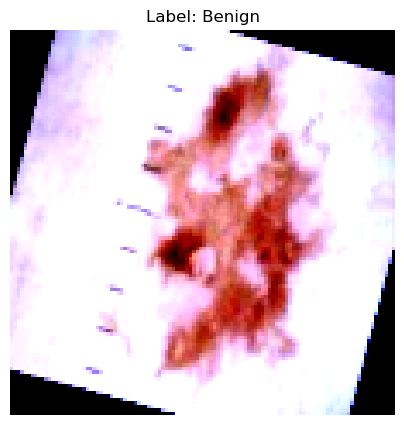

In [5]:
def show_image_label(image, label, dataset):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.permute(1, 2, 0))  # Convert from Tensor to numpy array and rearrange dimensions
    plt.title(f"Label: {dataset.classes[label]}")
    plt.axis('off')
    plt.show()

# Iterate over the data loader to get a batch of data
for images, labels in dataloader_train:
    # Choose one image and its label from the batch
    index = 100  # You can change this index to view different images
    image = images[index]
    label = labels[index]
    
    # Display the image with its label
    show_image_label(image, label, dataset_train)
    
    # Break the loop after displaying one image for demonstration purposes
    break

In [6]:
for data, target in dataloader_train:
    print(data.shape)  # This will print the shape of the input data
    print(target.shape)  # This will print the shape of the targets (if any)
    break

torch.Size([256, 3, 112, 112])
torch.Size([256])


## CNN Architecture

In [7]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()

        # Hyperparameters:
        self.in_channels = 3
        self.n_out = 32
        self.conv_kernel_size = 3
        self.conv_kernel_stride = 2
        self.conv_padding = 1
        self.pool_kernel_size = 2
        self.pool_kernel_stride = 2

        # Convolution
        self.conv1 = nn.Conv2d(self.in_channels, self.n_out, self.conv_kernel_size, self.conv_kernel_stride, self.conv_padding)
        self.conv2 = nn.Conv2d(self.n_out, self.n_out*2, self.conv_kernel_size, self.conv_kernel_stride, self.conv_padding)
        self.conv3 = nn.Conv2d(self.n_out*2, self.n_out*4, self.conv_kernel_size, self.conv_kernel_stride, self.conv_padding)

        # batch normalization
        self.bn1 = nn.BatchNorm2d(self.n_out)
        self.bn2 = nn.BatchNorm2d(self.n_out*2)
        self.bn3 = nn.BatchNorm2d(self.n_out*4)

        # Pooling
        self.pool1 = nn.MaxPool2d(self.pool_kernel_size, self.pool_kernel_stride)

        # Linear
        conv_output_size = self.get_conv_output_size()
        self.linear1 = nn.Linear(conv_output_size, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 2)

        # dropout
        self.dropout = nn.Dropout(0.35)

        self.sig = nn.Sigmoid()

    def get_conv_output_size(self):
        x = torch.zeros(1, self.in_channels, 112, 112)
        x = self.pool1(self.conv1(x))
        x = self.pool1(self.conv2(x))
        x = self.pool1(self.conv3(x))
        return x.view(-1).shape[0]

    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool1(F.leaky_relu(self.bn3(self.conv3(x))))
            
        x = x.view(x.size(0), -1)

        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.sig(self.linear3(x))

        return x

In [8]:
# Initialize the model
model = ConvNetwork()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

In [10]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, dataloader_train, criterion, optimizer)
    valid_loss, valid_accuracy = validate(model, dataloader_valid, criterion)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.4997, Train Accuracy: 0.8062, Valid Loss: 0.5044, Valid Accuracy: 0.8007
Epoch [2/10], Train Loss: 0.4660, Train Accuracy: 0.8431, Valid Loss: 0.4880, Valid Accuracy: 0.8214
Epoch [3/10], Train Loss: 0.4552, Train Accuracy: 0.8523, Valid Loss: 0.4709, Valid Accuracy: 0.8358
Epoch [4/10], Train Loss: 0.4516, Train Accuracy: 0.8550, Valid Loss: 0.4568, Valid Accuracy: 0.8516
Epoch [5/10], Train Loss: 0.4446, Train Accuracy: 0.8629, Valid Loss: 0.4644, Valid Accuracy: 0.8449
Epoch [6/10], Train Loss: 0.4410, Train Accuracy: 0.8662, Valid Loss: 0.4501, Valid Accuracy: 0.8527
Epoch [7/10], Train Loss: 0.4402, Train Accuracy: 0.8680, Valid Loss: 0.4389, Valid Accuracy: 0.8691
Epoch [8/10], Train Loss: 0.4334, Train Accuracy: 0.8748, Valid Loss: 0.4323, Valid Accuracy: 0.8793
Epoch [9/10], Train Loss: 0.4329, Train Accuracy: 0.8756, Valid Loss: 0.4534, Valid Accuracy: 0.8559
Epoch [10/10], Train Loss: 0.4330, Train Accuracy: 0.8768, Valid Loss: 0.4358, Valid Accura

In [34]:
def test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculation during inference
        for inputs, labels in test_loader:
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            # Store predictions and true labels for metric calculation
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    test_loss /= len(test_loader)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Print metrics including true positives and true negatives
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Get class labels
    classes = [str(i) for i in range(conf_matrix.shape[0])]  # Assuming class labels are integers

    # Visualize confusion matrix with Matplotlib
    plt.figure(figsize=(4, 3))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return accuracy

## Evaluate and save the model

Test Loss: 0.4351
Accuracy: 0.8748
Precision: 0.8309
Recall: 0.9215
F1 Score: 0.8739
ROC AUC Score: 0.8774


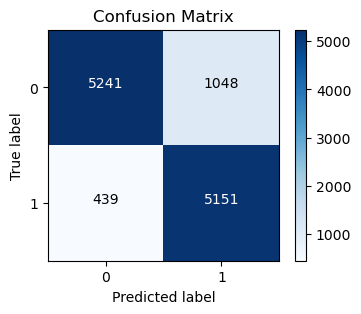

In [35]:
# Get accuracy
accuracy = test(model, dataloader_valid, criterion)

# Define folder to store model paths
current_dir = os.getcwd()
model_folder = 'Models'
models_dir = os.path.join(current_dir, model_folder)

# Define file paths including accuracy at the beginning of the filenames
architecture_path = os.path.join(models_dir, f"{accuracy:.2f}%_model_architecture.pth")
weights_path = os.path.join(models_dir, f"{accuracy:.2f}%_model_weights.pth")

# Save model architecture
torch.save(model, architecture_path)  # Save the entire model including architecture and weights

# Save model weights separately
torch.save(model.state_dict(), weights_path)  # Save only the model weights

The model demonstrates good performance with an accuracy of 87.52% and a ROC AUC score of 0.8779, indicating a strong ability to distinguish between classes.

Precision and Recall: The model exhibits a precision of 82.97%, meaning a low rate of false positives, and a recall of 92.45%, indicating it misses few true positive cases. The F1 score of 0.8745 reflects a good balance between these metrics.

The test loss of 0.4359 provides a measure of the model's prediction error. It is similat to training loss so i am not very concerned with overfitting.